In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
aux_columns = ['S5aux0', 'S3aux0', 'S2aux0', 'S0aux0', 'S0aux1', 'S0aux2',
       'S0aux3', 'S2aux1', 'S2aux2', 'S2aux3', 'S0aux4', 'S0aux5',
       'S0aux6', 'S0aux7', 'S0aux8']
out_columns = ['0', '1', '2']
MODEL_NAME = "XGB_apart_old"

In [9]:
vars_list_input = ['S0x0','S0x1','S0x2','S0x3','S0x4','S3x0','S3x1','S2x0','S2x1','S2x2','S2x3','S0x5','S0x6',
 'S0x7','S0x8','S0x9','S0x10','S1x0','S1x1','S1x2','S1x3','S1x4','S1x5','S5x0','S4x0','S4x1','S4x2','S3x2','S4x3',
 'S4x4','S5x1','S5x2','S5x3','S5x4','S4x5']

## XGBoost for PID Classification

### Train data

In [21]:
xgb_train_df = pd.read_csv("./data/orig_train_old.csv")
xgb_train = {}
for pid in range(6):
    train_pid = xgb_train_df[xgb_train_df.pid==pid]
    xgb_train[pid] = train_pid[vars_list_input].values

### Test data

#### original data

In [305]:
xgb_test_df = pd.read_csv('./data/orig_test_old.csv')
xgb_test = {pid: {} for pid in range(6)}
for pid in range(6):
    test_pid = xgb_test_df[xgb_test_df.pid==pid]
    xgb_test[pid]['data'] = test_pid[vars_list_input].values
    xgb_test[pid]['S0aux7'] = test_pid["S0aux7"].values
    xgb_test[pid]['S0aux8'] = test_pid["S0aux8"].values

#### data after AE

In [285]:
scalers = {var: {} for var in ['S0aux7', 'S0aux8']}
for i, var in enumerate(['S0aux7', 'S0aux8']):
    scalers[var]['std'] = joblib.load(os.path.join('preprocessors', "scaler_std_"+var) + ".pkl")
    scalers[var]['max'] = joblib.load(os.path.join('preprocessors', "scaler_max_"+var) + ".pkl")

In [286]:
ae_test_df = pd.read_csv('./data/ae_test_pid_{}_old.csv'.format(3))
ae_test = {pid: {} for pid in range(6)}


    
for pid in range(6):
    test_pid = ae_test_df[ae_test_df.pid==pid]
    ae_test[pid]['data'] = test_pid[vars_list_input].values
    ae_test[pid]['S0aux7'] = test_pid["S0aux7"].values
    ae_test[pid]['S0aux8'] = test_pid["S0aux8"].values
    
    for i, var in enumerate(['S0aux7', 'S0aux8']):
        ae_test[pid][var] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(ae_test[pid][var].reshape(-1, 1))
        ).reshape(-1)

#### data after AE+GAN

In [287]:
gan_test_df = pd.read_csv('./data/gan_ae_test_dim_{}_old.csv'.format(3))
gan_test = {pid: {} for pid in range(6)}
for pid in range(6):
    test_pid = gan_test_df[gan_test_df.pid==pid]
    gan_test[pid]['data'] = test_pid[vars_list_input].values
    gan_test[pid]['S0aux7'] = test_pid["S0aux7"].values
    gan_test[pid]['S0aux8'] = test_pid["S0aux8"].values
    
    for i, var in enumerate(['S0aux7', 'S0aux8']):
        gan_test[pid][var] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(gan_test[pid][var].reshape(-1, 1))
        ).reshape(-1)

-------------

Train all the xgboost models

In [145]:
for pid1 in range(6):
    for pid2 in range(pid1+1, 6):
        X = np.concatenate([xgb_train[pid1], xgb_train[pid2]], axis=0)
        Y = [0]*len(xgb_train[pid1]) + [1]*len(xgb_train[pid2])
        
        clf_name = "XGBoost_old_pids_{}-{}".format(pid1, pid2)
        clf = xgb.XGBClassifier(nthread=-1, seed=111)
        clf.fit(X, Y)
        joblib.dump(clf, os.path.join('xgboost', clf_name) + ".pkl")
#         clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

### Kaon(f, #5) vs Peon(a, #0)

In [205]:
clf_name = "XGBoost_old_pids_{}-{}".format(0, 5)
clf = xgb.XGBClassifier(nthread=-1, seed=111)
clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

In [206]:
def get_sorted_ans(clf, data, pid_pos, pid_neg, aux='S0aux7'):
    X = np.concatenate([data[pid_neg]['data'], data[pid_pos]['data']], axis=0)
    Y = [0]*len(data[pid_neg]['data']) + [1]*len(xgb_test[pid_pos]['data'])
    y_pred = clf.predict_proba(X)[:, 1]
    aux = np.concatenate([xgb_test[pid_neg][aux], xgb_test[pid_pos][aux]], axis=0)
    sorted_ans = np.array([[x, y, z] for x, (y, z) in zip(y_pred, zip(Y, aux))])
    sorted_ans = np.array(sorted(sorted_ans, key=lambda x: x[2]))
    return sorted_ans[:, 0], sorted_ans[:, 1], sorted_ans[:, 2]

In [290]:
def tpr_fpr(y_true, y_pred):
    tp = np.sum(y_true*y_pred)
    fn = np.sum((1-y_pred)*y_true)
    tn = np.sum((1-y_pred)*(1-y_true))
    fp = np.sum((1-y_true)*y_pred)
    
    return tp/(tp+fn), fp/(fp+tn)

def get_plot_data(pred, true, aux, thres=0.5, true_label=1, bins=20):
    pred = np.array([0 if x < thres else 1 for x in pred])
    true = np.array([1 if x == true_label else 0 for x in true])
    
    
    tprs, fprs = [], []
    
    step = (np.max(aux) - np.min(aux))/bins
    indices = [0]
    aux_index = 0
    for n_step in range(1, bins+1):
        while aux[aux_index] < np.min(aux)+step*n_step:
            aux_index += 1
        indices.append(aux_index)
    
    for i in range(1, len(indices)):
        tpr, fpr = tpr_fpr(true[indices[i-1]:indices[i]], pred[indices[i-1]:indices[i]])
        tprs.append(tpr)
        fprs.append(fpr)
        
    return [(aux[indices[i]] + aux[indices[i-1]])/2 for i in range(1, bins+1)], tprs, fprs

def plot(x, ys, legends, aux='S0aux7', title='', alpha=0.5):
    plt.figure(figsize=(10, 6))
    
    for y, label in zip(ys, legends):
        plt.scatter(x, y, alpha=alpha, label=label)
    
    plt.ylim(-0.2, 1.2)
    plt.xlabel('{} bins'.format(aux))
    plt.ylabel('Efficiency')
    plt.legend(loc="upper left")
    plt.title(title)

In [311]:
def plot_efficiency(data, clf, feature_name, clf_threshold, max_feature_value, title=""):
    pred, true, aux = get_sorted_ans(clf, data, 5, 0, aux=feature_name)

    last_index = -1
    for i in range(len(aux)):
        if aux[i] >= max_feature_value:
            last_index = i
            break
    
    x, tpr, fpr = get_plot_data(pred[:last_index], true[:last_index], aux[:last_index], thres=0.5)
    plot(x, [tpr, fpr], 
         legends=["Kaon identification efficiency", "Pion misidentification rate"], 
         aux=feature_name, title=title)

    plt.show()
    
def plot_hist(data, feature_name, max_feature_value, bins=20):

    indices = []
    for i in range(len(data)):
        if data[i] < max_feature_value:
            indices.append(i)
    
    plt.figure(figsize=(10, 6))
    plt.xlabel('{} value'.format(feature_name))
    plt.ylabel('num of {} values per bin'.format(feature_name))
    plt.hist(data[indices], bins=bins, histtype='step')
    plt.title('{} values histogram'.format(feature_name))
    plt.show()

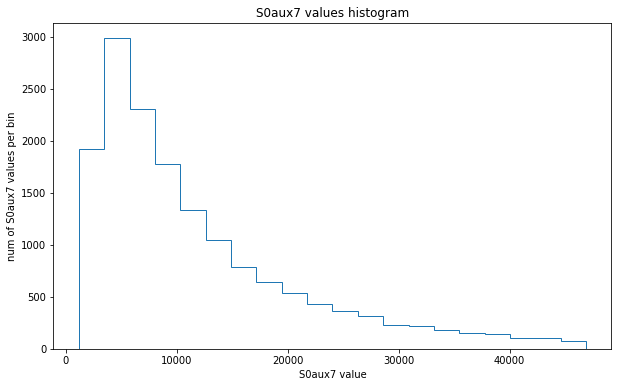

In [309]:
plot_hist(xgb_test[pid]['S0aux7'], 'S0aux7', 46885, bins=20)

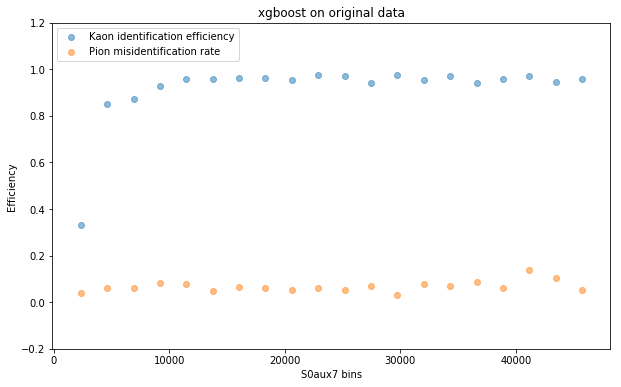

In [312]:
plot_efficiency(xgb_test, clf, 'S0aux7', 0.5, 46885, title="xgboost on original data")

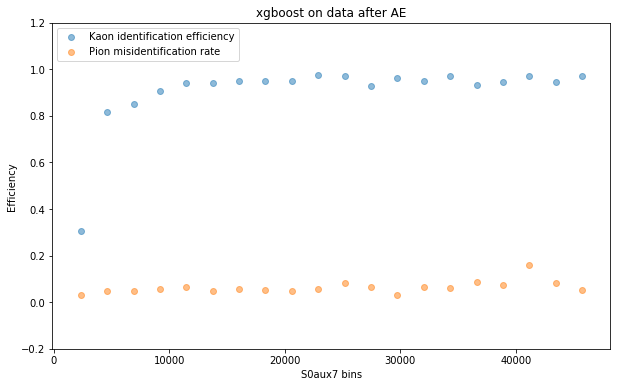

In [313]:
plot_efficiency(ae_test, clf, 'S0aux7', 0.5, 46885, title="xgboost on data after AE")

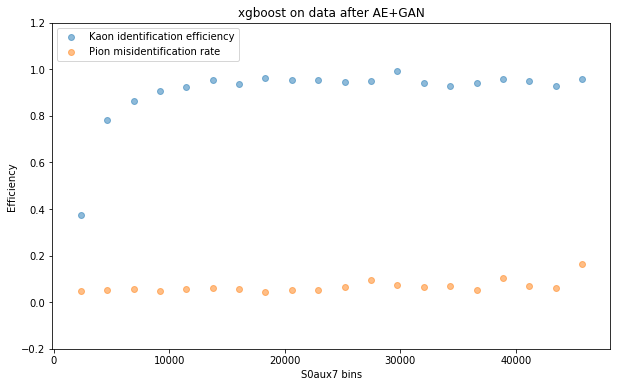

In [314]:
plot_efficiency(gan_test, clf, 'S0aux7', 0.5, 46885, title="xgboost on data after AE+GAN")